In [1]:
from _shared import *

## Задача 1. Сколько выбросов удалять

С одной стороны, при удалении выбросов снижается дисперсия, что приводит к увеличению чувствительности теста. С другой стороны, при удалении выбросов уменьшается размер выборки, что приводит к уменьшению чувствительности.

Сравните мощности тестов с разной долей удаляемых данных:
- Используйте данные о времени работы бэкенда `2022-04-01T12_df_web_logs.csv` в период с __2022-03-01__ по __2022-03-08__.
- Уровень значимости — 0.05.
- Размеры групп — 1000 человек (размер выборок будет больше, так как на одного человека приходится много значений).
- Проверяем гипотезу о равенстве средних с помощью теста Стьюдента.
- Ожидаемый эффект — увеличение времени обработки на 1%.
- Эффект в синтетических А/В-тестах добавляем умножением на константу.

В ответ введите номера вариантов, упорядоченные по уменьшению мощности. Например, «12345» означает, что вариант 1 обладает наибольшей мощностью, а вариант 5 — наименьшей.

1. Удалить 0.02% выбросов;
2. Удалить 0.2% выбросов;
3. Удалить 2% выбросов;
4. Удалить 10% выбросов;
5. Удалить 20% выбросов.

Удалить 2% выбросов означает, что нужно убрать по 1% минимальных и максимальных значений выборки. То есть оставить значения, которые лежат между `np.quantile(values, 0.01)` и `np.quantile(values, 0.99)`. Квантили вычислять для каждой из групп отдельно.

In [2]:
target_metric = 'load_time' #mean per user.

filename = '2022-04-01T12_df_web_logs.csv'
begin_date = '2022-03-01'
end_date = '2022-03-08'

alpha = 0.05
criterion = stats.ttest_ind

group_size = 1000
effect_type = 'mul'
mde = +0.01

filter_quantiles = np.array([0.02, 0.20, 2.00, 10.00, 20.00]) / 100.0
filter_quantiles

array([0.0002, 0.002 , 0.02  , 0.1   , 0.2   ])

In [3]:
df_web_logs = get_data_subset(
    df=read_from_database(filename, [2]),
    begin_date=begin_date,
    end_date=end_date,
    user_ids=None,
    columns=['date', 'user_id', 'load_time']
)

df_web_logs.head()

,date,user_id,load_time
885082,2022-03-01 00:00:02,434cf2,69.8
885083,2022-03-01 00:00:06,80fa93,86.3
885084,2022-03-01 00:02:20,434cf2,58.0
885085,2022-03-01 00:02:53,a0aaab,85.2
885086,2022-03-01 00:03:00,a22f92,92.5


In [4]:
rng = np.random.default_rng(132)

def remove_outliers_quantile(values: pd.Series, quantile_num: float=0.01):
    return values.loc[
        (values > np.quantile(values, quantile_num / 2.0))
        & (values < np.quantile(values, 1.0 - quantile_num / 2.0))
    ]


def get_error_rates_outlier(df, N, outlier_quantiles, metric, effect_size, effect_type, rnd_perc=0.01):
    error_rates = { oq: [] for oq in outlier_quantiles }

    users = df['user_id'].unique()
    
    for _ in range(N):
        users_sub = np.random.choice(users, group_size * 2, replace=False)
        group_a, group_b = users_sub[:group_size], users_sub[group_size:]
        
        df_sub = (
            df
            .loc[
                df['user_id'].isin(users_sub),
                ['user_id', metric]
            ].copy()
        )
        
        for k in error_rates.keys():
            sales_a = df_sub.loc[df_sub['user_id'].isin(group_a), metric]
            sales_b = df_sub.loc[df_sub['user_id'].isin(group_b), metric]
            
            if effect_type == 'mul':
                sales_b = sales_b * (1 + effect_size)
                
            elif effect_type == 'add':
                effect = df_sub[metric].mean() * effect_size
                sales_b = sales_b + effect

            elif effect_type == 'rnd':
                effect = df_sub[metric].mean() * effect_size * group_size / (group_size * rnd_perc) #Focus mde_price in the few affected users (very not obvious).
                sales_b = sales_b + (rng.random(size=sales_b.shape[0]) < rnd_perc) * effect 
                
            sales_a = remove_outliers_quantile(sales_a, k)
            sales_b = remove_outliers_quantile(sales_b, k)
            
            error_rates[k].append(stats.ttest_ind(sales_a, sales_b).pvalue)
        
    return pd.DataFrame(error_rates)

In [5]:
error_rates = get_error_rates_outlier(
    df=df_web_logs,
    N=10_000,
    outlier_quantiles=filter_quantiles,
    metric=target_metric,
    effect_size=mde,
    effect_type='mul'
)

error_rates.head()

,0.0002,0.0020,0.0200,0.1000,0.2000
0,0.159028,0.009517,7.626790e-06,1.110794e-06,1.406493e-07
1,0.257262,0.012271,3.582215e-02,3.806434e-02,1.581423e-02
2,0.090787,0.002685,3.201695e-09,5.439845e-11,8.808953e-14
3,0.330273,0.025376,1.169857e-04,2.117740e-06,2.054127e-08
4,0.042843,0.206723,3.301313e-05,5.022290e-07,5.254318e-09


Type II rates:
0.0002 - 0.9067
0.0020 - 0.6567
0.0200 - 0.0660
0.1000 - 0.0415
0.2000 - 0.0300


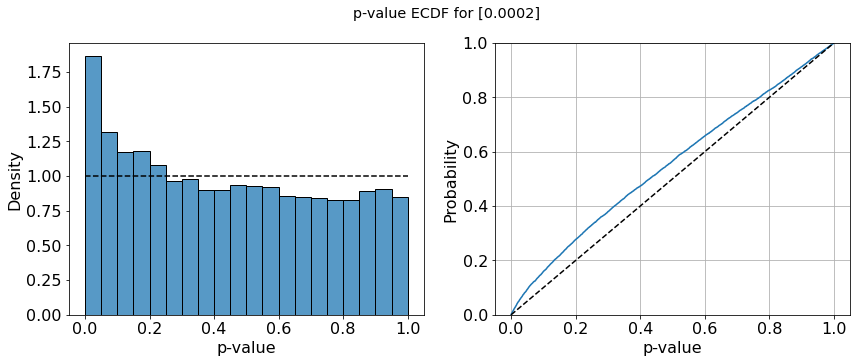

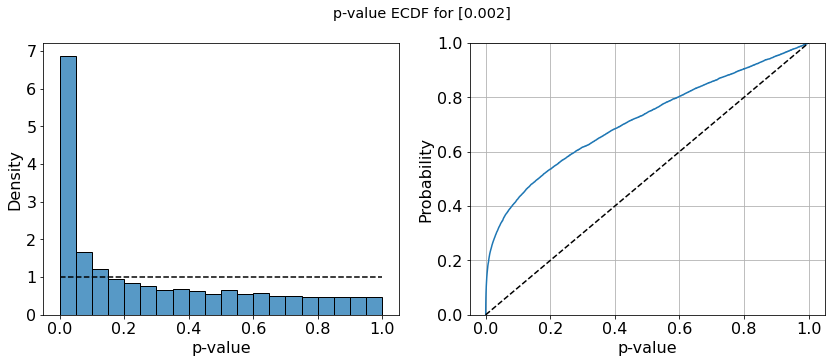

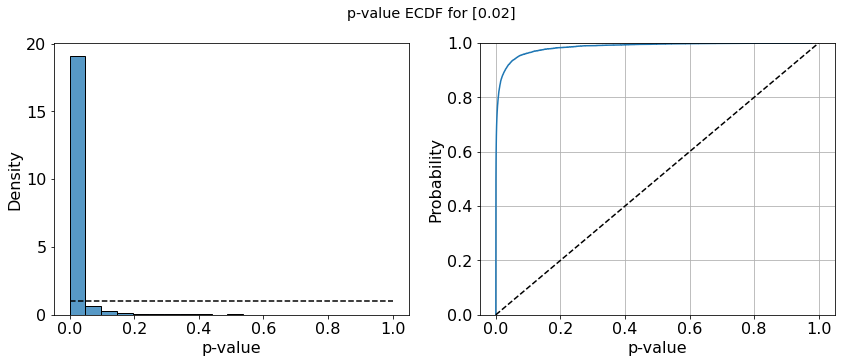

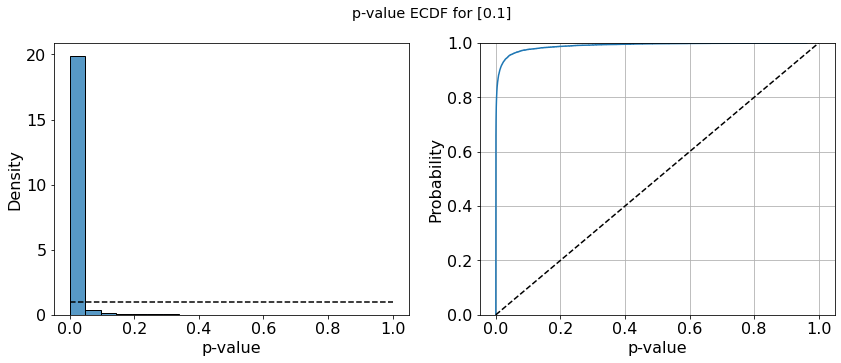

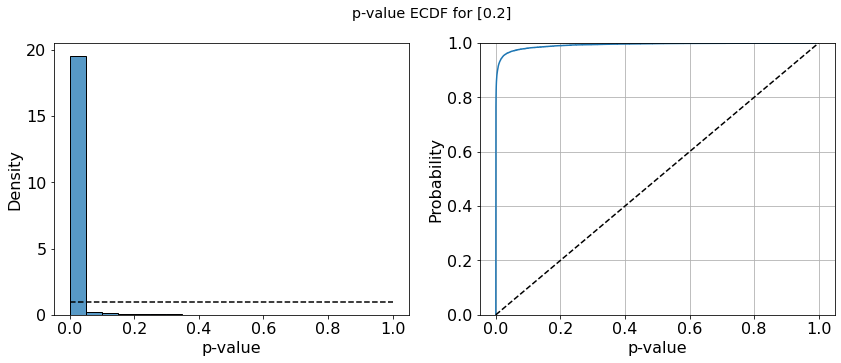

In [6]:
print('Type II rates:')
for col in error_rates.columns:
    print('{:.4f} - {:.4f}'.format(col, (error_rates[col] > alpha).mean()))
    plot_pvalue_ecdf(error_rates[col], 'p-value ECDF for [{}]'.format(col))

In [7]:
df_answer = (error_rates > alpha).mean().reset_index()
df_answer.columns = ['quantile', 'type_ii_rate']

df_answer['rnk'] = df_answer['quantile'].rank()

df_answer.sort_values('type_ii_rate')
#Answer is "54321".

,quantile,type_ii_rate,rnk
4,0.2000,0.0300,5.0
3,0.1000,0.0415,4.0
2,0.0200,0.0660,3.0
1,0.0020,0.6567,2.0
0,0.0002,0.9067,1.0


In [8]:
# Solution
import os
from datetime import datetime
import numpy as np
import pandas as pd
from scipy import stats

URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_web_logs = read_database('2022-04-01T12_df_web_logs.csv')
df_web_logs['date'] = pd.to_datetime(df_web_logs['date'])

begin_date = datetime(2022, 3, 1)
end_date = datetime(2022, 3, 8)
df_metrics = (
    df_web_logs
    [(df_web_logs['date'] >= begin_date) & (df_web_logs['date'] < end_date)]
    [['user_id', 'load_time']]
)
users = df_metrics['user_id'].unique()

sample_size = 1000
effect = 0.01
alpha = 0.05
quantiles = (0.0001, 0.001, 0.01, 0.05, 0.1,)
quantile2errors = {q: [] for q in quantiles}

for _ in range(10000):
    a_users, b_users = np.random.choice(users, (2, sample_size,), False)
    a_values = df_metrics.loc[df_metrics['user_id'].isin(a_users), 'load_time'].values
    b_values = (
        df_metrics.loc[df_metrics['user_id'].isin(b_users), 'load_time'].values
        * (1 + effect)
    )
    for q in quantiles:
        a_values_filtered = a_values[
            (a_values > np.quantile(a_values, q))
            & (a_values < np.quantile(a_values, 1-q))
        ]
        b_values_filtered = b_values[
            (b_values > np.quantile(b_values, q))
            & (b_values < np.quantile(b_values, 1-q))
        ]
        pvalue = stats.ttest_ind(a_values_filtered, b_values_filtered).pvalue
        quantile2errors[q].append(pvalue > alpha)

def process_results(quantile2errors):
    """Обрабатываем данные и выводим результат."""
    # список из элементов: номер варианта, квантиль, доля ошибок, список ошибок).
    data = [
        (idx+1, quantile, np.mean(errors), errors,)
        for idx, (quantile, errors) in enumerate(quantile2errors.items())
    ]
    # сортируем по доле ошибок
    data.sort(key=lambda x: x[2])

    # проверим, что оценки мощности значимо отличаются друг от друга
    print(f'idx={data[0][0]} quantile={data[0][1]}, power={1-data[0][2]:0.3f}')
    for i in range(1, len(data)):
        pvalue = stats.ttest_ind(data[i][3], data[i-1][3]).pvalue
        if pvalue < 0.05:
            msg = f'pvalue={pvalue:0.4f}, оценка мощности значимо отличается от предыдущей'
        else:
            msg = f'pvalue={pvalue:0.4f}, оценка мощности не отличается значимо от предыдущей'
        print(f'idx={data[i][0]} quantile={data[i][1]}, power={1-data[i][2]:0.3f}, {msg}')
    print('answer:', ''.join([str(x[0]) for x in data]))

process_results(quantile2errors)


idx=5 quantile=0.1, power=0.971
idx=4 quantile=0.05, power=0.961, pvalue=0.0001, оценка мощности значимо отличается от предыдущей
idx=3 quantile=0.01, power=0.938, pvalue=0.0000, оценка мощности значимо отличается от предыдущей
idx=2 quantile=0.001, power=0.342, pvalue=0.0000, оценка мощности значимо отличается от предыдущей
idx=1 quantile=0.0001, power=0.090, pvalue=0.0000, оценка мощности значимо отличается от предыдущей
answer: 54321


## Задача 2. Сколько выбросов удалять — 2

Выполните то же задание, изменив способ добавления эффекта. Эффект в синтетических А/В-тестах добавляем добавлением константы к 1% данных.

В ответ введите номера вариантов упорядоченные по уменьшению мощности. Например, «12345» означает, что вариант 1 обладает наибольшей мощностью, а вариант 5 — наименьшей.

1. Удалить 0.02% выбросов;
2. Удалить 0.2% выбросов;
3. Удалить 2% выбросов;
4. Удалить 10% выбросов;
5. Удалить 20% выбросов.

Удалить 2% выбросов означает, что нужно убрать по 1% минимальных и максимальных значений выборки. То есть оставить значения, которые лежат между `np.quantile(values, 0.01)` и `np.quantile(values, 0.99)`. Квантили вычислять для каждой из групп отдельно.

In [9]:
error_rates2 = get_error_rates_outlier(
    df=df_web_logs,
    N=10_000,
    outlier_quantiles=filter_quantiles,
    metric=target_metric,
    effect_size=mde,
    effect_type='rnd',
    rnd_perc=0.01
)

error_rates2.head()

,0.0002,0.0020,0.0200,0.1000,0.2000
0,0.960370,0.645191,0.000048,0.001167,0.002322
1,0.371485,0.050767,0.000223,0.002580,0.008780
2,0.480143,0.000027,0.012845,0.138863,0.178677
3,0.635589,0.513276,0.025854,0.038952,0.029037
4,0.189308,0.014253,0.001124,0.003382,0.008136


Type II rates:
0.0002 - 0.8787
0.0020 - 0.5481
0.0200 - 0.2008
0.1000 - 0.4695
0.2000 - 0.4884


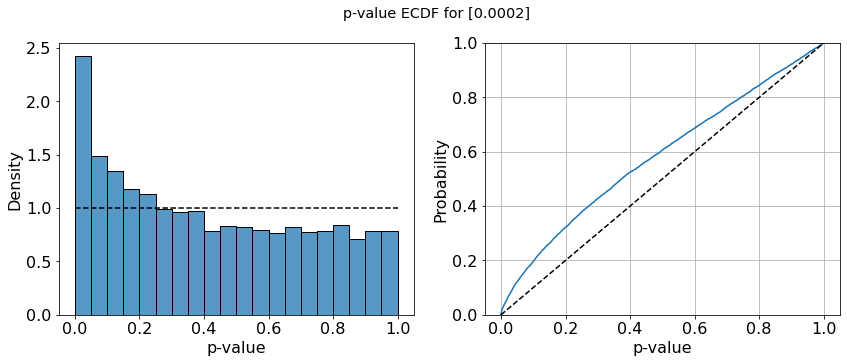

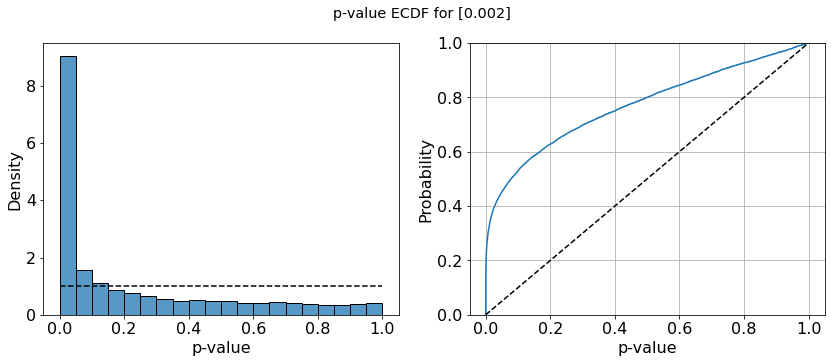

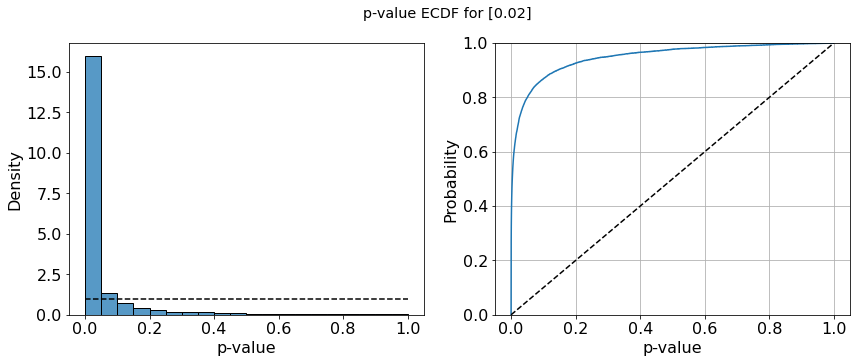

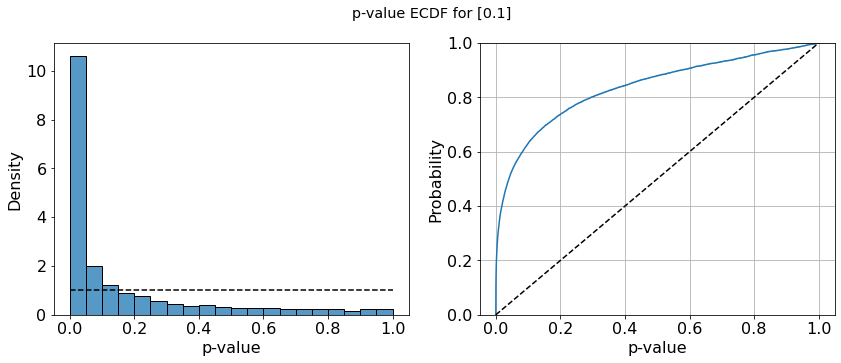

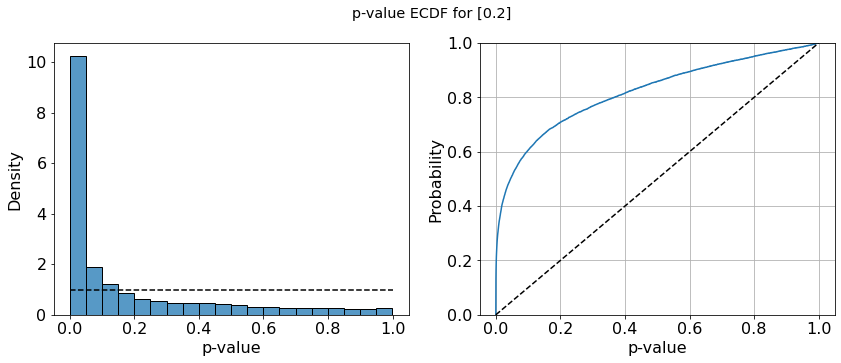

In [12]:
print('Type II rates:')
for col in error_rates2.columns:
    print('{:.4f} - {:.4f}'.format(col, (error_rates2[col] > alpha).mean()))
    plot_pvalue_ecdf(error_rates2[col], 'p-value ECDF for [{}]'.format(col))

In [11]:
df_answer2 = (error_rates2 > alpha).mean().reset_index()
df_answer2.columns = ['quantile', 'type_ii_rate']

df_answer2['rnk'] = df_answer2['quantile'].rank()

df_answer2.sort_values('type_ii_rate')
#Answer is "34521".

,quantile,type_ii_rate,rnk
2,0.0200,0.2008,3.0
3,0.1000,0.4695,4.0
4,0.2000,0.4884,5.0
1,0.0020,0.5481,2.0
0,0.0002,0.8787,1.0


## Задача 3. Функция удаления выбросов

In [13]:
"""
Реализуйте функцию process_outliers.

Шаблон решения
"""
import pandas as pd


def process_outliers(metrics, bounds, outlier_process_type):
    """Возвращает новый датафрейм с обработанными выбросами в измерениях метрики.

    :param metrics (pd.DataFrame): таблица со значениями метрики
        со столбцами ['user_id', 'metric'].
    :param bounds (tuple[float, float]): нижняя и верхняя границы метрики. Всё что
        не попало между ними считаем выбросами.
    :param outlier_process_type (str): способ обработки выбросов. Возможные варианты:
        'drop' - удаляем измерение,
        'clip' - заменяем выброс на значение ближайшей границы (lower_bound, upper_bound).
    :return df: таблица со столбцами ['user_id', 'metric']
    """
    res = metrics.copy()
    
    if outlier_process_type == 'drop':
        res = res.loc[
            (res['metric'] >= bounds[0])
            & (res['metric'] <= bounds[1]),
            :
        ]

    if outlier_process_type == 'clip':
        # res['metric'] = res['metric'].apply(lambda x: min(max(x, bounds[0]), bounds[1]))
        res.loc[res['metric'] < bounds[0],'metric'] = bounds[0]
        res.loc[res['metric'] > bounds[1],'metric'] = bounds[1]

    return res

In [14]:
metrics = pd.DataFrame({'user_id': [1, 2, 3], 'metric': [1., 2, 3]})
bounds = (0.1, 2.2,)

outlier_process_type = 'drop'
result = process_outliers(metrics, bounds, outlier_process_type)
# result = pd.DataFrame({'user_id': [1, 2], 'metric': [1.0, 2.0]})
result

,user_id,metric
0,1,1.0
1,2,2.0


In [15]:
outlier_process_type = 'clip'
result = process_outliers(metrics, bounds, outlier_process_type)
# result = pd.DataFrame({'user_id': [1, 2, 3], 'metric': [1.0, 2.0, 2.2]})
result

,user_id,metric
0,1,1.0
1,2,2.0
2,3,2.2


In [16]:
# Solution
def process_outliers(metrics, bounds, outlier_process_type):
    lower_bound, upper_bound = bounds
    metrics = metrics.copy()
    if outlier_process_type == 'drop':
        metrics = metrics[(metrics['metric'] >= lower_bound) & (metrics['metric'] <= upper_bound)]
    elif outlier_process_type == 'clip':
        metrics.loc[metrics['metric'] < lower_bound, 'metric'] = lower_bound
        metrics.loc[metrics['metric'] > upper_bound, 'metric'] = upper_bound
    else:
        raise ValueError('Неверное значение outlier_process_type')
    return metrics